In [1]:
%matplotlib inline
import xarray as xr
import matplotlib.pyplot as plt
import iris
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
from glob import glob
from netCDF4 import Dataset
import wrf
ena = {'lat': 39, 'lon': 360 - 28}

## Load datasets

In [2]:
ds_obs = xr.open_dataset('/Users/jone003/tmp/EAGLES/arm_data/enainterpolatedsondeC1.c1.20170718.000030.nc')
# ds_obs

In [3]:
ds_era = xr.open_dataset('/Users/jone003/tmp/EAGLES/ERA5_ENA_20170717-20170719_with_height_and_presl.nc')
# ds_era

### Load WRF
WRF simulation was with one grid (no nesting) centered at ENA, extending +/- ~1 degree, using 82 vertical levels (eta levels shown in cell below), with 3000 m horizontal grid spacing (55 x 60 grid cells) and 10 second timestep.

In [4]:
# wrf_output = sorted(glob('/Users/jone003/tmp/EAGLES/WRF/wrfout*'))
wrf_output = sorted(glob('/Users/jone003/tmp/EAGLES/WRF/output_wrf/ena_2017_07_18/wrfout_d01_2017-07-1*'))
wrf_in = [Dataset(f) for f in wrf_output]

In [5]:
lat = wrf.getvar(wrf_in, 'lat', timeidx=wrf.ALL_TIMES, method="cat")
lon = wrf.getvar(wrf_in, 'lon', timeidx=wrf.ALL_TIMES, method='cat')
temp = wrf.getvar(wrf_in, 'tc', timeidx=wrf.ALL_TIMES, method='cat')
theta = wrf.getvar(wrf_in, 'theta', timeidx=wrf.ALL_TIMES, method='cat')
z = wrf.getvar(wrf_in, 'z', timeidx=wrf.ALL_TIMES, method='cat')
rh = wrf.getvar(wrf_in, 'rh', timeidx=wrf.ALL_TIMES, method='cat')
u = wrf.getvar(wrf_in, 'ua', timeidx=wrf.ALL_TIMES, method='cat')
v = wrf.getvar(wrf_in, 'va', timeidx=wrf.ALL_TIMES, method='cat')

In [6]:
qvapor = wrf.getvar(wrf_in, 'QVAPOR', timeidx=wrf.ALL_TIMES, method='cat')
q = qvapor / (1 + qvapor)  # specific humidity

In [23]:
lon.isel(Time=0, south_north=59, west_east=60)

<xarray.DataArray 'XLONG' ()>
array(-28.018066, dtype=float32)
Coordinates:
    XLONG     float32 -28.018066
    XLAT      float32 39.080753
    Time      datetime64[ns] 2017-07-17T18:00:00
    datetime  datetime64[ns] 2017-07-17T18:00:00
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  LONGITUDE, WEST IS NEGATIVE
    units:        degree_east
    stagger:      
    coordinates:  XLONG XLAT
    projection:   LambertConformal(stand_lon=-28.030000686645508, moad_cen_la...

In [21]:
lat.isel(Time=0, south_north=59, west_east=[58, 59, 60, 61])

<xarray.DataArray 'XLAT' (west_east: 4)>
array([39.080753, 39.080753, 39.080753, 39.080753], dtype=float32)
Coordinates:
    XLONG     (west_east) float32 -28.065765 -28.041931 -28.018066 -27.994232
    XLAT      (west_east) float32 39.080753 39.080753 39.080753 39.080753
    Time      datetime64[ns] 2017-07-17T18:00:00
    datetime  datetime64[ns] 2017-07-17T18:00:00
Dimensions without coordinates: west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  LATITUDE, SOUTH IS NEGATIVE
    units:        degree_north
    stagger:      
    coordinates:  XLONG XLAT
    projection:   LambertConformal(stand_lon=-28.030000686645508, moad_cen_la...

In [24]:
ena_wrf = {'south_north': 26, 'west_east': 27}  # approx 28W, 39N (original version)
# updated version at 59, 60
ena_wrf = {'south_north': 59, 'west_east': 60}  # approx 28W, 39N (original version)

In [25]:
ds_wrf = xr.Dataset({'temp': temp,
                        'u_wind': u,
                        'v_wind': v,
                        'sh': q,
                        'potential_temp': theta,
                        'height': z / 1000}
                   )
ds_wrf_ena = ds_wrf.isel(**ena_wrf).sel(Time='2017-07-18')

In [12]:
newer_eta_levels = [1.000, 0.999, 0.995, 0.990, 0.985, 0.980, 0.975,
                    0.970, 0.965, 0.960, 0.955, 0.950, 0.945, 0.940, 
                    0.935, 0.930, 0.925, 0.920, 0.915, 0.910, 0.905,
                    0.900, 0.895, 0.891, 0.888, 0.886, 0.884, 0.882,
                    0.880, 0.870, 0.860, 0.847208, 0.8110777, 0.770949, 0.7275254, 
                    0.6840308, 0.642961, 0.6041809, 0.5675629, 0.5329864, 0.5003376, 
                    0.4695089, 0.440399, 0.412912, 0.3869574, 0.3624499, 0.3393086, 
                    0.3174575, 0.2968247, 0.2773421, 0.2589457, 0.2415749, 0.2251725, 
                    0.2096847, 0.1950603, 0.1812512, 0.168212, 0.1558996, 0.1442738, 
                    0.1332961, 0.1229305, 0.1131427, 0.1039006, 0.09517372, 0.08693343, 
                    0.07915249, 0.07180537, 0.06486785, 0.05831715, 0.05213161, 0.04629095, 
                    0.04077588, 0.03556832, 0.03065106, 0.02600794, 0.0216237, 0.01748388, 
                    0.01357488, 0.009883763, 0.006398458, 0.003107458, 0]
len(newer_eta_levels)

82

In [ ]:
print('lev', 'eta', 'z (m)', sep='\t')
for i in range(len(newer_eta_levels) - 1):
    print(i, round(newer_eta_levels[i + 1], 3),
          round(ds_wrf_ena.height.isel(Time=6).values[i] * 1000, 2),
          sep='\t')

In [26]:
# adjusted eta levels again for better vertical resolution / spacing near BL top
newest_eta_levels = [1.000, 0.999, 0.995, 0.990, 0.985, 0.980, 0.975, 0.970, 0.965, 0.960,
    0.955, 0.950, 0.945, 0.940, 0.935, 0.930, 0.925, 0.920, 0.915, 0.910,
    0.905, 0.900, 0.895, 0.891, 0.888, 0.886, 0.884, 0.882, 0.880, 0.878,
    0.875, 0.870, 0.865, 0.860, 0.850, 0.840, 0.826, 0.8110777, 0.770949, 0.7275254,
    0.6840308, 0.642961, 0.6041809, 0.5675629, 0.5329864, 0.5003376,
    0.4695089, 0.440399, 0.412912, 0.3869574, 0.3624499, 0.3393086,
    0.3174575, 0.2968247, 0.2773421, 0.2589457, 0.2415749, 0.2251725,
    0.2096847, 0.1950603, 0.1812512, 0.168212, 0.1558996, 0.1442738,
    0.1332961, 0.1229305, 0.1131427, 0.1039006, 0.09517372, 0.08693343,
    0.07915249, 0.07180537, 0.06486785, 0.05831715, 0.05213161, 0.04629095,
    0.04077588, 0.03556832, 0.03065106, 0.02600794, 0.0216237, 0.01748388,
    0.01357488, 0.009883763, 0.006398458, 0.003107458, 0]
len(newest_eta_levels)

87

In [27]:
print('lev', 'eta', 'z (m)', sep='\t')
for i in range(len(newest_eta_levels) - 1):
    print(i, round(newest_eta_levels[i + 1], 3),
          round(ds_wrf_ena.height.isel(Time=6).values[i] * 1000, 2),
          sep='\t')

lev	eta	z (m)
0	0.999	59.74
1	0.995	80.52
2	0.99	118.03
3	0.985	159.86
4	0.98	201.85
5	0.975	243.99
6	0.97	286.29
7	0.965	328.75
8	0.96	371.36
9	0.955	414.14
10	0.95	457.07
11	0.945	500.16
12	0.94	543.41
13	0.935	586.82
14	0.93	630.41
15	0.925	674.19
16	0.92	718.17
17	0.915	762.35
18	0.91	806.71
19	0.905	851.24
20	0.9	895.93
21	0.895	940.83
22	0.891	981.46
23	0.888	1013.25
24	0.886	1036.08
25	0.884	1054.42
26	0.882	1072.82
27	0.88	1091.26
28	0.878	1109.75
29	0.875	1132.94
30	0.87	1170.16
31	0.865	1216.87
32	0.86	1263.83
33	0.85	1334.79
34	0.84	1430.12
35	0.826	1545.92
36	0.811	1687.27
37	0.771	1964.11
38	0.728	2397.77
39	0.684	2870.17
40	0.643	3352.44
41	0.604	3830.69
42	0.568	4304.56
43	0.533	4773.85
44	0.5	5238.75
45	0.47	5698.99
46	0.44	6153.79
47	0.413	6603.06
48	0.387	7047.01
49	0.362	7485.79
50	0.339	7919.71
51	0.317	8348.39
52	0.297	8770.85
53	0.277	9186.72
54	0.259	9596.05
55	0.242	9999.06
56	0.225	10395.85
57	0.21	10786.44
58	0.195	11170.99
59	0.181	11549.98
60	0.168	11923.85


In [5]:
ds_era_ena = ds_era.sel(**ena, time='2017-07-18')
for i, t in enumerate(ds_era_ena['height'].isel(time=0).values * 1000):
    print(i, t, sep='\t')

0	77346.71186206488
1	72378.24945702487
2	69980.17621995989
3	67685.7023030933
4	65515.92794306333
5	63451.19971362914
6	61471.78852022186
7	59557.276151397324
8	57688.78528702742
9	55858.977054906325
10	54066.87296344823
11	52312.68378611186
12	50599.26673169269
13	48929.213664350085
14	47305.35984915602
15	45735.93620629998
16	44238.50136981566
17	42829.338012926826
18	41508.30234671285
19	40266.858360284714
20	39098.70859788964
21	38001.93453378829
22	36969.9254771517
23	35989.627421441866
24	35052.86292940491
25	34155.06282345664
26	33293.48766341142
27	32467.87750320736
28	31676.389516910232
29	30915.467672849863
30	30184.135263936947
31	29482.042725247884
32	28807.01332053381
33	28157.217540156256
34	27531.580194379596
35	26928.072703139038
36	26344.033006614984
37	25778.068585260804
38	25230.346777035404
39	24700.783011295105
40	24187.901131953855
41	23690.015511719736
42	23206.47001284027
43	22737.41333906258
44	22282.948295181428
45	21842.70481662946
46	21416.001363470023
47	2

# Compare ERA5 reanalysis to ARM obs at ENA site

In [29]:
zobs = ds_obs['height']
height = ds_era['height']  # dims ('lev', 'time', 'lat', 'lon')

In [30]:
# optionally interpolate ds_era to same height levels as obs ds
# should make it easier to compare directly, but not really needed if just plotting
def interp_to_height(ds_era, height_obs):
    height = ds_era['height'].transpose('time', 'lev', 'lat', 'lon')  # originally (lev, time, lat, lon)
    height = height[:, ::-1, :, :]  # ordered as increasing height
    ax0 = height.dims.index('lev')
    
    var_list = [v for v in ds_era if 'lev' in ds_era[v].dims]  # time, lev, lat, lon
    
    time = ds_era.time.values
    lat = ds_era.lat.values
    lon = ds_era.lon.values
    ntime = len(time)
    nlat = len(lat)
    nlon = len(lon)
    nheight = len(height_obs)
    out_shape = (ntime, nheight, nlat, nlon)
    
    ds_out = xr.Dataset()
    ds_out['height'] = height_obs
    # easiest to just loop over columns (even if that feels dumb)
    # new output has shape time, nheight, nlat, nlon
    for v in var_list:
        print(v)
        if v == 'height':
            continue
        # note: need to reverse order so height increases
        arr_in = ds_era[v].transpose('time', 'lev', 'lat', 'lon').values[:, ::-1, :, :]
        arr_out = np.full(out_shape, np.nan)
        print(arr_out.shape)
        print(arr_in.shape)
        for jt in range(ntime):
            for jlat in range(nlat):
                for jlon in range(nlon):
                    arr_out[jt, :, jlat, jlon] = np.interp(height_obs.values,
                                                           height[jt, :, jlat, jlon],
                                                           arr_in[jt, :, jlat, jlon])
        da = xr.DataArray(arr_out, coords=[time, height_obs, lat, lon],
                          dims=['time', 'height', 'lat', 'lon'],
                          name=v,
                          attrs=ds_era[v].attrs)
        ds_out[v] = da.copy(deep=True)
    return ds_out

In [31]:
ds_era_height = interp_to_height(ds_era, zobs)
# ds_era_height

TMP
(72, 332, 9, 9)
(72, 137, 9, 9)
SPFH
(72, 332, 9, 9)
(72, 137, 9, 9)
UGRD
(72, 332, 9, 9)
(72, 137, 9, 9)
VGRD
(72, 332, 9, 9)
(72, 137, 9, 9)
height
pressure
(72, 332, 9, 9)
(72, 137, 9, 9)


In [32]:
theta = ds_era_height['TMP'] * (1000 * 100 / ds_era_height['pressure']) ** (0.286)
theta.attrs = {'units': 'K', 'long_name': 'potential temperature'}
ds_era_height['potential_temp'] = theta
ds_era_height

<xarray.Dataset>
Dimensions:         (height: 332, lat: 9, lon: 9, time: 72)
Coordinates:
  * height          (height) float32 0.03048 0.05048 ... 40.510487 41.010487
  * time            (time) datetime64[ns] 2017-07-17 ... 2017-07-19T23:00:00
  * lat             (lat) float32 40.0 39.75 39.5 39.25 ... 38.5 38.25 38.0
  * lon             (lon) float32 331.0 331.25 331.5 ... 332.5 332.75 333.0
Data variables:
    TMP             (time, height, lat, lon) float64 294.9 294.6 ... 261.7 261.8
    SPFH            (time, height, lat, lon) float64 0.01439 ... 3.702e-06
    UGRD            (time, height, lat, lon) float64 5.04 4.342 ... -31.5 -31.63
    VGRD            (time, height, lat, lon) float64 6.525 6.75 ... -2.478
    pressure        (time, height, lat, lon) float64 1.023e+05 ... 265.1
    potential_temp  (time, height, lat, lon) float64 293.0 292.7 ... 1.428e+03

In [33]:
# for initial comparison, select lat, lon = (39, -28)
ds_era_ena = ds_era.sel(**ena, time='2017-07-18')
if 'lev' in ds_era_height:
    ds_era_height_ena = ds_era_height.drop('lev').sel(**ena, time='2017-07-18')
else:
    ds_era_height_ena = ds_era_height.sel(**ena, time='2017-07-18')    

In [34]:
# Hourly resample obs
ds_obs_hourly = ds_obs.resample(time='1H').mean()
ds_obs_hourly

/anaconda3/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:            (height: 332, time: 24)
Coordinates:
  * time               (time) datetime64[ns] 2017-07-18 ... 2017-07-18T23:00:00
  * height             (height) float32 0.03048 0.05048 ... 40.510487 41.010487
Data variables:
    precip             (time) float32 0.0 0.0 0.0 0.0 ... 8.3333333e-07 0.0 0.0
    qc_precip          (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    temp               (time, height) float32 22.19273 22.217276 ... nan nan
    qc_temp            (time, height) float64 0.0 0.0 0.0 0.0 ... 4.0 4.0 4.0
    source_temp        (time, height) float64 1.0 1.0 1.0 1.0 ... nan nan nan
    rh                 (time, height) float32 94.79914 93.27482 ... nan nan
    qc_rh              (time, height) float64 0.0 0.0 0.0 0.0 ... 4.0 4.0 4.0
    source_rh          (time, height) float64 1.0 1.0 1.0 1.0 ... nan nan nan
    vap_pres           (time, height) float32 2.5351167 2.4980872 ... nan nan
    qc_vap_pres        (time, height) float64 

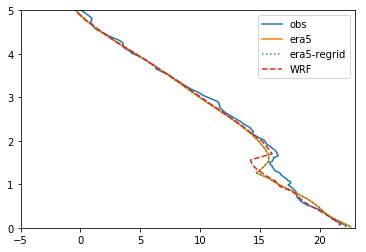

In [35]:
# sanity check to verify regridding of era5 was reasonable
i = 0
z_obs = ds_obs_hourly.height
plt.plot(ds_obs_hourly.temp.isel(time=i), z_obs)
plt.plot(ds_era_ena.TMP.isel(time=i) - 273.15, ds_era_ena.height.isel(time=0))
plt.plot(ds_era_height_ena.TMP.isel(time=i) - 273.15, ds_era_height_ena.height,':')
plt.plot(ds_wrf_ena.temp.isel(Time=i), ds_wrf_ena.height.isel(Time=i),'--')
plt.ylim([0, 5])
plt.xlim([-5, 23])
plt.legend(['obs', 'era5', 'era5-regrid', 'WRF'])

In [36]:
# join era and obs:
ds1 = ds_era_height_ena.rename({'TMP': 'temp',
                                'UGRD': 'u_wind',
                                'VGRD': 'v_wind',
                                'SPFH': 'sh'}).drop(['lat', 'lon'])
if ds1['temp'].min() > 50:
    # convert to celsius
    ds1['temp'].values = ds1['temp'].values - 273.15
vars_to_combine = ['temp', 'u_wind', 'v_wind', 'sh']
ds_combined = xr.concat([ds1[vars_to_combine], ds_obs_hourly[vars_to_combine]],
                        dim=pd.Index(('ERA5', 'Obs'), name='data'))

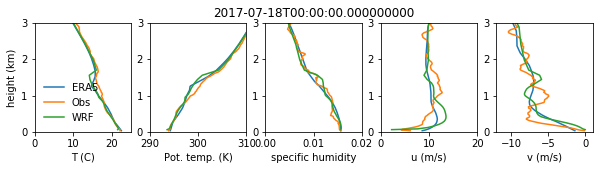

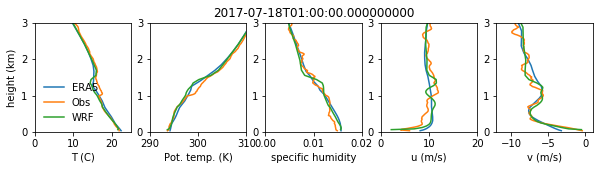

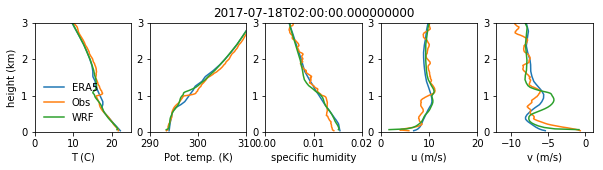

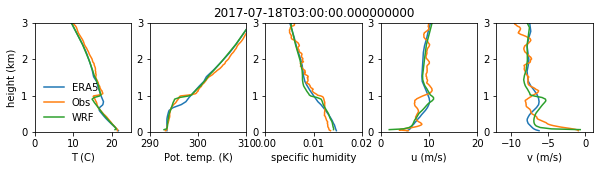

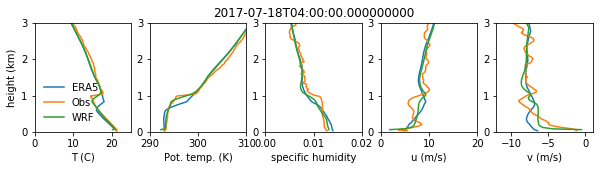

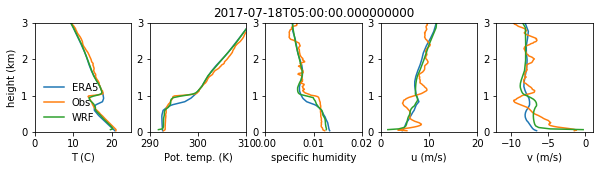

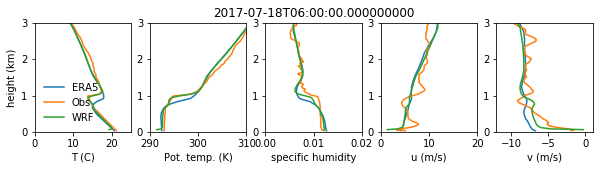

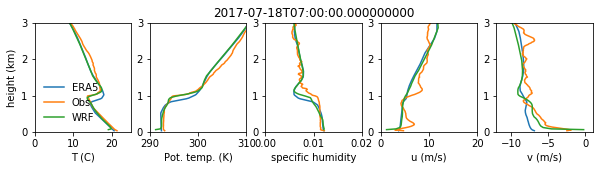

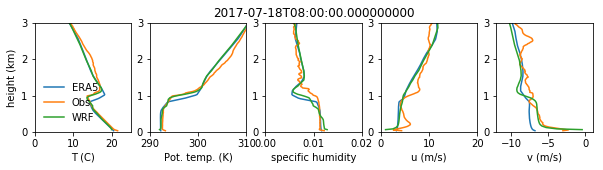

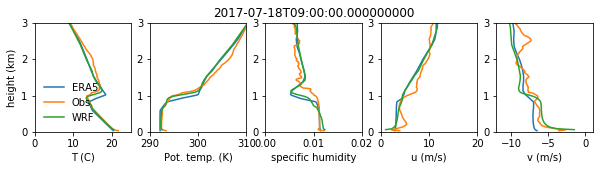

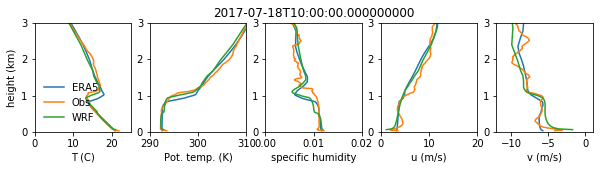

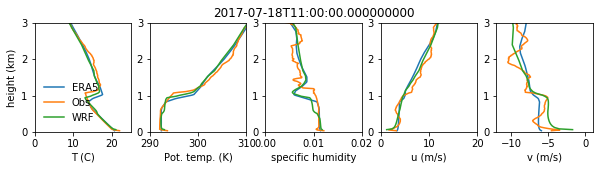

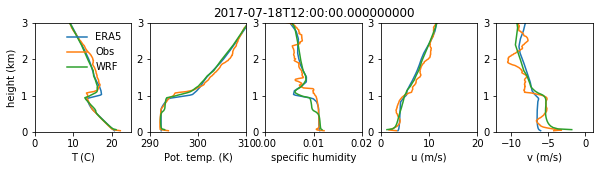

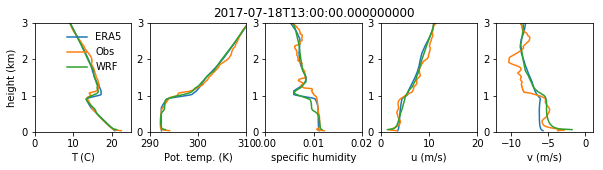

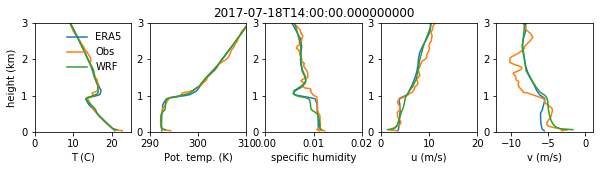

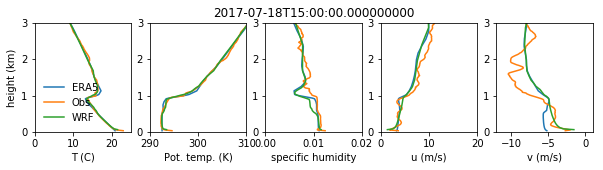

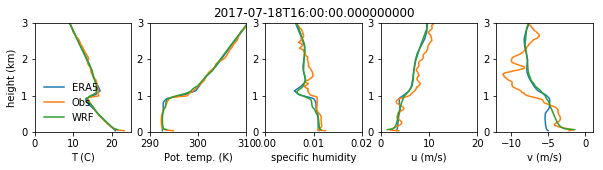

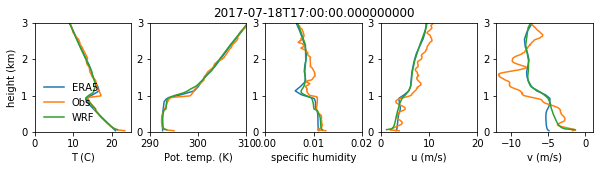

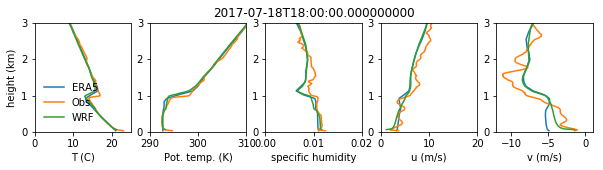

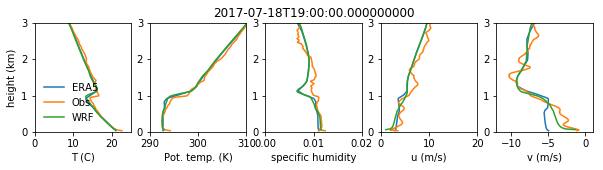

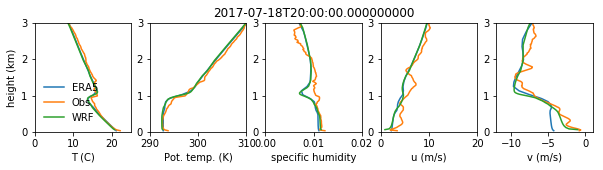

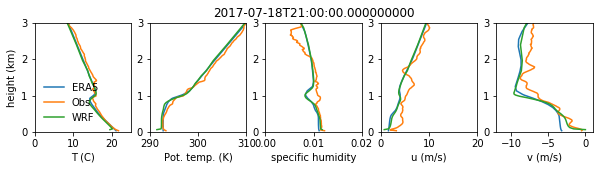

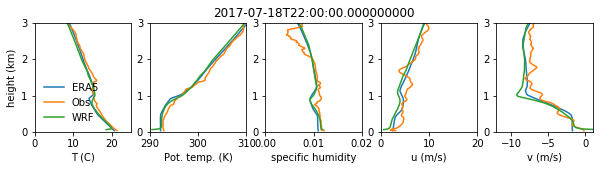

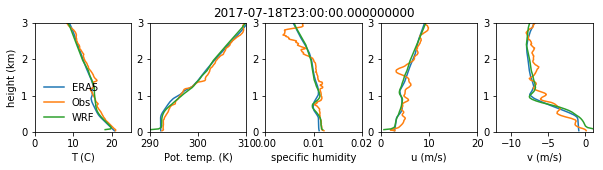

In [37]:
# make a long set of plots:
# all together together: 
#    fig, axes = plt.subplots(ncols=5, nrows=24, figsize=(8, 48)
# but, it looks better if they're all separate instead

save_fig = False
z = ds_combined.height
ylims = [0, 3]
xlims = [(0, 25), (290, 310), (0, 0.02), (0, 20), (-12, 1)]
ylab = 'height (km)'
xlab = ['T (C)', 'Pot. temp. (K)', 'specific humidity', 'u (m/s)', 'v (m/s)']
for n in range(len(ds1.time)):
    fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(10, 2))
    for j, v in enumerate(['temp', 'potential_temp', 'sh', 'u_wind', 'v_wind']):
        ax = axes[j]  
        ax.plot(ds1[v].isel(time=n), z)
        ax.plot(ds_obs_hourly[v].isel(time=n), z)
        ax.plot(ds_wrf_ena[v].isel(Time=n), ds_wrf_ena.height.isel(Time=n))
        ax.set_ylim(ylims)
        ax.set_xlim(xlims[j])
        if (j == 0):
            ax.legend(['ERA5', 'Obs', 'WRF'], frameon=False)
        if j == 0:
            ax.set_ylabel(ylab)
        if j == 2:
            ax.set_title(ds1.time.values[n])
        ax.set_xlabel(xlab[j])
    if save_fig:
        out_name = f'era5_v_wrf_v_obs_ena_20170718_{n:02}.png'
        fig.savefig(out_name)
    plt.show()